# Analysis 17: Candidate Gene Orthologs

# Setup

In [ ]:
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Attaching package: 'data.table'

The following objects are masked from 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year

The following objects are masked from 'package:dplyr':

    between, first, last

The following object is masked from 'package:purrr':

    transpose

# Inputs

`candidate_out_name` - path to the candidate file output by `analysis/call_candidate_genes.qmd` and then modified in `analysis/candidate_gene_effects.qmd`, and finally `analysis/candidate_gene_organization.qmd`

`orthos` - data frame of human orthologs for C. elegans genes downloaded from http://ortholist.shaye-lab.org/

In [ ]:
candidate_out_name <- "data/processed/interval_genes/candidate_genes/inbred_candidate_genes_table.tsv"

orthos_fn <- "data/raw/orthologs/ortholist_master.xlsx"


# Main

Filter candidates to those in ranked QTL and unqiue genes

In [ ]:
cg <- data.table::fread(candidate_out_name)

fg <- cg %>%
  dplyr::filter(!is.na(`Interval Rank`)) %>%
  dplyr::arrange(`Interval Rank`, Interval, Gene)

# get the gene list for human orthos
genes <- fg$Gene


Load the ortholog data

In [ ]:
# get the ortholist from here: http://ortholist.shaye-lab.org/
orthos <- readxl::read_xlsx(orthos_fn)

ortho_gens <- fg %>%
  dplyr::left_join(., orthos, by = c("Gene" = "Common Name")) %>%
  dplyr::left_join(., orthos, by = c("Gene" = "Locus ID"))


Merge the gene data with the ortholog data

In [ ]:
# A function to merge the .x and .y columns from duplicate joins
merge_xy <- function(df) {
  xcols <- grep("\\.x$", names(df), value = TRUE)
  bases <- sub("\\.x$", "", xcols)
  ycols <- paste0(bases, ".y")

  # keep only pairs that exist in both .x and .y
  keep <- ycols %in% names(df)
  xcols <- xcols[keep]
  ycols <- ycols[keep]
  bases <- bases[keep]

  # build merged columns, drop originals
  for (i in seq_along(bases)) {
    df[[bases[i]]] <- dplyr::coalesce(df[[xcols[i]]], df[[ycols[i]]])
  }
  df %>% dplyr::select(-all_of(c(xcols, ycols)))
}

ogm <- merge_xy(ortho_gens) %>%
  dplyr::group_by(Gene) %>%
  dplyr::arrange(desc(`No. of Programs`), .by_group = T) %>%
  dplyr::ungroup()
head(ogm)


# A tibble: 6 × 23
  Interval  Marker Gene  Details WBGeneID `Interval Rank` Log10p `LD (r2)`   MAF
  <chr>     <chr>  <chr> <chr>   <chr>              <int>  <dbl>     <dbl> <dbl>
1 Chloroth… III:7… B028… Putati… WBGene0…               9  10.4      0.890 0.349
2 Paraquat… II:13… C01B… Unchar… WBGene0…              16   6.98     0.928 0.159
3 Chloroth… III:7… C06E… Unchar… WBGene0…               9  10.9      0.851 0.359
4 Chloroth… III:6… C23G… FBA_2 … WBGene0…               9   8.98     0.831 0.364
5 Chloroth… III:4… C35D… Unchar… WBGene0…               9  10.9      0.932 0.338
6 Chloroth… III:3… C44F… Unchar… WBGene0…               9   9.37     0.851 0.359
# ℹ 14 more variables: `Beta Coefficient` <dbl>, `Reference Allele` <chr>,
#   `Alternative Allele` <chr>, `Locus ID` <chr>, `Common Name` <chr>,
#   `WormBase ID` <chr>, `Ahringer RNAi Clone Location` <chr>,
#   `Ensembl ID` <chr>, `HGNC Symbol` <chr>, `No. of Programs` <dbl>,
#   Databases <chr>, `SMART IDs` <chr>, `InterPro Doma

Get a summary of orthologs found

ℹ Please use `after_stat(count)` instead.

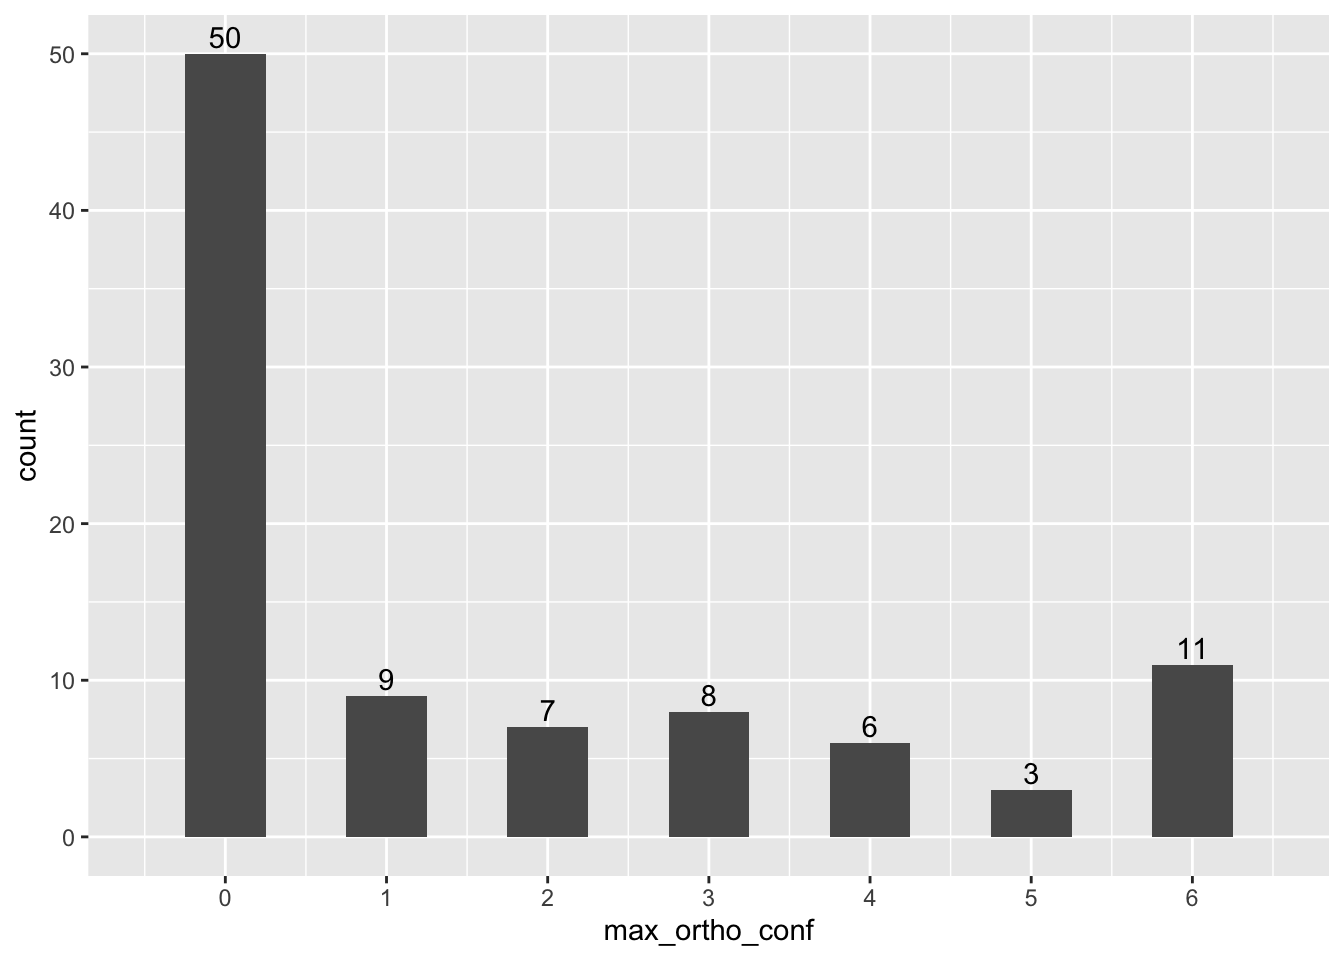

In [ ]:
og_sum <- ogm %>%
  dplyr::group_by(Gene) %>%
  dplyr::arrange(desc(`No. of Programs`), .by_group = T) %>%
  dplyr::mutate(
    hum_ortho = ifelse(!is.na(`No. of Programs`), T, F),
    max_ortho_conf = max(`No. of Programs`),
    max_ortho_conf = ifelse(is.na(max_ortho_conf), 0, max_ortho_conf)
  ) %>%
  dplyr::distinct(Gene, .keep_all = T) %>%
  dplyr::ungroup()

# Show distribution of confidence in orthos
ggplot(og_sum) +
  aes(x = max_ortho_conf) +
  geom_histogram(binwidth = .5) +
  stat_bin(
    binwidth = 1, geom = "text", aes(label = ..count..),
    vjust = -0.3
  ) +
  scale_x_continuous(breaks = 0:6)


# Output

Write the candidate genes with orthologs to file

In [ ]:
output_fn <- "data/processed/interval_genes/candidate_genes/inbred_candidate_genes_with_human_orthologs.tsv"

ogm %>%
  data.table::fwrite(output_fn, sep = "\t", na = "NA", quote = F)
